#### Bayesian Logit Normal Inference
We assume that the logit transformation of our response, 
$$z_i = \log\left(\frac{y_i}{1-y_i}\right)$$
is modeled as
$$z_i \sim \mathcal{N}(X_i\beta,\,\sigma^2)$$
This means that the likelihood is
$$L(\beta,\sigma^2\mid z) \propto (2\pi\sigma^2)^{-n/2}\exp\!\Bigl\{-\frac{1}{2\sigma^2}(z-X\beta)^\top(z-X\beta)\Bigr\}$$
Using Jeffrey's prior, we have:
$$\pi(\beta,\sigma^2) \propto \frac{1}{\sigma^{p+2}}$$
Which leads (after some algebra) to closed form conditionals:
- Conditional for $\beta$ given $\sigma^2$:
$$\beta\mid\sigma^2,z \sim \mathcal{N}\Bigl(\hat{\beta},\,\sigma^2 (X^\top X)^{-1}\Bigr)$$
with $\hat{\beta} = (X^\top X)^{-1}X^\top z$.

- Conditional for $\sigma^2$ given $\beta$:
$$\sigma^2\mid\beta,z \sim \text{Inverse-Gamma}\Bigl(\frac{n}{2},\,\frac{\text{SSE}}{2}\Bigr)$$
where $\text{SSE} = (z-X\beta)^\top(z-X\beta)$

In [795]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import logit
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import invgamma, multivariate_normal,multivariate_t
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/alexkoutromanos/Documents/GitHub/Bayesian-Logit-Normal-Reg/justice_score.csv', encoding='ISO-8859-1')
df


,score_JG,country_name_ltn,nuts_id,gend,edu,emp,age,urban,ethni_groups
0,0.351852,Austria,AT1,2,3.0,1,50,1,0.0
1,0.055556,Austria,AT1,2,6.0,1,49,1,0.0
2,0.500000,Austria,AT1,1,3.0,6,70,2,1.0
3,0.944444,Austria,AT1,2,5.0,7,39,1,1.0
4,0.500000,Austria,AT1,1,7.0,7,53,1,0.0
...,...,...,...,...,...,...,...,...,...
27703,0.055556,Sweden,SE3,2,7.0,1,31,1,0.0
27704,0.944444,Sweden,SE3,2,5.0,1,28,1,0.0
27705,0.055556,Sweden,SE3,1,4.0,3,26,1,0.0
27706,0.500000,Sweden,SE3,1,4.0,1,55,2,0.0


In [796]:
df.columns

Index(['score_JG', 'country_name_ltn', 'nuts_id', 'gend', 'edu', 'emp', 'age',
       'urban', 'ethni_groups'],
      dtype='object')

In [797]:
df = df.loc[
    (df['gend'] != 98) & (df['gend'] != 99) & (df['gend'] != 4) & (df['gend'] != 3) &
    (df['edu']  != 98) & (df['edu']  != 99) &
    (df['emp']  != 98) & (df['emp']  != 99) &
    (df['age']  != 98) & (df['age']  != 99) &
    (df['urban']!= 98) & (df['urban']!= 99)
 ]

df = df.dropna(subset = ['country_name_ltn', 'nuts_id', 'gend', 'edu', 'emp', 'age',
       'urban', 'ethni_groups'])

<Axes: ylabel='Density'>

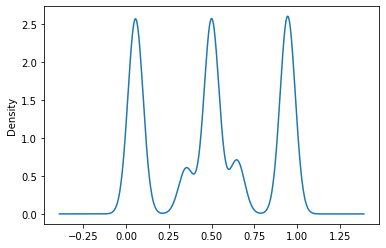

In [798]:
df['score_JG'].plot(kind= 'kde')

<Axes: ylabel='Density'>

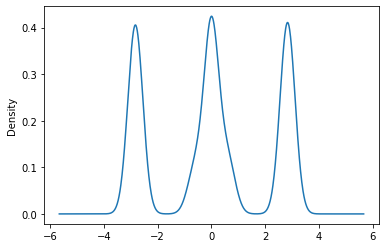

In [799]:
log_score = logit(df['score_JG'])
log_score.plot(kind='kde')

In [800]:
df['gend'] = df['gend'].apply(lambda x: 0 if x == 2 else 1)
df['urban'] = df['urban'].apply(lambda x: 0 if x == 2 else 1)

df

,score_JG,country_name_ltn,nuts_id,gend,edu,emp,age,urban,ethni_groups
0,0.351852,Austria,AT1,0,3.0,1,50,1,0.0
1,0.055556,Austria,AT1,0,6.0,1,49,1,0.0
2,0.500000,Austria,AT1,1,3.0,6,70,0,1.0
3,0.944444,Austria,AT1,0,5.0,7,39,1,1.0
4,0.500000,Austria,AT1,1,7.0,7,53,1,0.0
...,...,...,...,...,...,...,...,...,...
27703,0.055556,Sweden,SE3,0,7.0,1,31,1,0.0
27704,0.944444,Sweden,SE3,0,5.0,1,28,1,0.0
27705,0.055556,Sweden,SE3,1,4.0,3,26,1,0.0
27706,0.500000,Sweden,SE3,1,4.0,1,55,0,0.0


In [801]:
# Maybe we should explore scaling ALL of these values, Idk why but just seems like it could maybe help... 
df_grouped = df.groupby(['country_name_ltn','nuts_id']).mean().reset_index()
df_grouped

,country_name_ltn,nuts_id,score_JG,gend,edu,emp,age,urban,ethni_groups
0,Austria,AT1,0.506216,0.484848,5.013986,2.904429,45.965035,0.715618,0.610723
1,Austria,AT2,0.503779,0.428571,4.997449,2.918367,46.872449,0.599490,0.573980
2,Austria,AT3,0.516629,0.431122,4.961735,2.711735,45.418367,0.635204,0.517857
3,Belgium,BE1,0.538249,0.487273,4.996364,2.909091,42.250909,1.000000,0.465455
4,Belgium,BE2,0.520412,0.466667,4.404444,3.368889,48.022222,0.928889,0.653333
...,...,...,...,...,...,...,...,...,...
102,Spain,ES6,0.494926,0.486301,4.917808,2.760274,45.044521,0.897260,0.000000
103,Spain,ES7,0.544269,0.434911,5.032544,2.618343,43.775148,0.934911,0.000000
104,Sweden,SE1,0.503688,0.481328,4.887967,2.576763,43.124481,0.879668,0.000000
105,Sweden,SE2,0.485111,0.452261,4.959799,2.834171,47.346734,0.683417,0.000000


<Axes: ylabel='Density'>

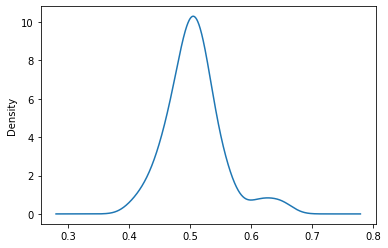

In [802]:
df_grouped.score_JG.plot(kind = 'kde')

<Axes: ylabel='Density'>

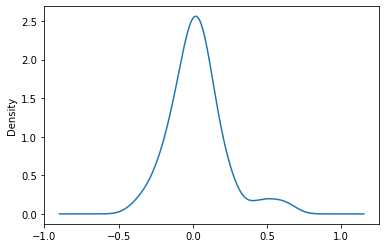

In [803]:
X = logit(df_grouped.score_JG)
X.plot(kind = 'kde')

In [804]:
Y = df_grouped[["gend","edu","emp","age","urban","ethni_groups"]]
Y

,gend,edu,emp,age,urban,ethni_groups
0,0.484848,5.013986,2.904429,45.965035,0.715618,0.610723
1,0.428571,4.997449,2.918367,46.872449,0.599490,0.573980
2,0.431122,4.961735,2.711735,45.418367,0.635204,0.517857
3,0.487273,4.996364,2.909091,42.250909,1.000000,0.465455
4,0.466667,4.404444,3.368889,48.022222,0.928889,0.653333
...,...,...,...,...,...,...
102,0.486301,4.917808,2.760274,45.044521,0.897260,0.000000
103,0.434911,5.032544,2.618343,43.775148,0.934911,0.000000
104,0.481328,4.887967,2.576763,43.124481,0.879668,0.000000
105,0.452261,4.959799,2.834171,47.346734,0.683417,0.000000


<Axes: >

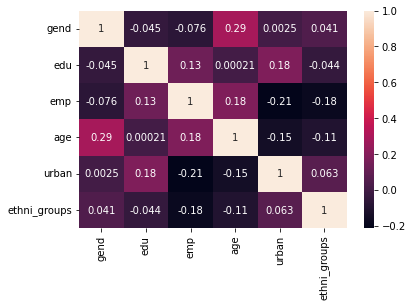

In [805]:
sns.heatmap(Y.corr(),annot=True)


In [806]:
# This is flipped because my X and Y were flipped further up 
Y_train,Y_test,X_train, X_test = train_test_split(X,Y,test_size=0.2)

In [807]:
p = X_train.shape[1]
n = X_train.shape[0]
beta_0 = np.zeros(p)  
V_0 = np.eye(p) * 10
a_0, b_0 = 2, 2 

In [808]:
eps = 1e-6
Y_train = np.clip(Y_train, eps, 1 - eps)
Y_train = np.log(Y_train / (1 - Y_train))

V_n = np.linalg.inv(X_train.T @ X_train + np.linalg.inv(V_0))
beta_n = V_n @ (X_train.T @ Y_train + np.linalg.inv(V_0) @ beta_0)
a_n = a_0 + n / 2
b_n = b_0 + 0.5 * ((Y_train - X_train @ beta_n).T @ (Y_train - X_train @ beta_n)) + 0.5 * np.trace(X_train.T @ X_train @ V_n)

# sigma2_sample = invgamma.rvs(a_n, scale=b_n, size=1) 
# beta_sample = multivariate_t.rvs(beta_n, V_n) 

sigma2_sample = invgamma.rvs(a_n, scale=b_n, size=1)
beta_sample = multivariate_normal.rvs(mean=beta_n, cov=sigma2_sample * V_n)

mu_pred = X_test @ beta_sample
logit_samples = np.random.normal(mu_pred, np.sqrt(sigma2_sample)) 
y_pred = 1 / (1 + np.exp(-logit_samples))

# Y_test = (Y_test - np.min(Y_test)) / (np.max(Y_test) - np.min(Y_test))

In [809]:
def MSE_RMSE_MAE_R2(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    ss_total = np.sum((y_test - np.mean(y_test)) ** 2)  
    ss_residual = np.sum((y_test - y_pred) ** 2)  
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else float("nan") 
    MSE = np.mean((y_test - y_pred) ** 2)
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(y_test - y_pred))
    return MSE, RMSE, MAE, r2
MSE, RMSE, MAE, R2 = MSE_RMSE_MAE_R2(Y_test, y_pred)

print(f"Model Performance Metrics:")
print("--------------------------------")
print(f"Mean Squared Error (MSE)  : {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE) : {RMSE:.4f}")
print(f"Mean Absolute Error (MAE) : {MAE:.4f}")
print(f"R² Score : {R2:.4f}")


Model Performance Metrics:
--------------------------------
Mean Squared Error (MSE)  : 0.1265
Root Mean Squared Error (RMSE) : 0.3557
Mean Absolute Error (MAE) : 0.2350
R² Score : -3.4075


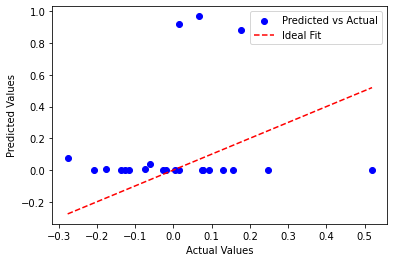

In [810]:
plt.scatter(Y_test, y_pred, color="blue", label="Predicted vs Actual")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color="red", linestyle="dashed", label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


<Axes: ylabel='Density'>

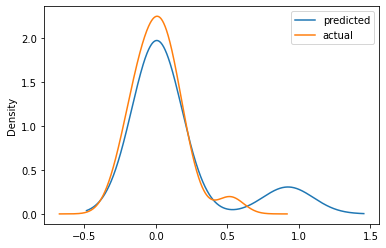

In [811]:
Y_test = np.array(Y_test)
comparisons = pd.DataFrame({"predicted": y_pred, "actual": Y_test})
comparisons
comparisons.plot(kind='kde')

Text(0.5, 1.0, 'Distribution of Predictions vs. Actuals')

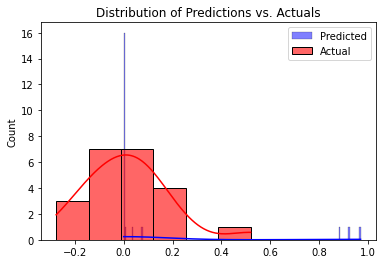

In [812]:
sns.histplot(y_pred, kde=True, color="blue", label="Predicted")
sns.histplot(Y_test, kde=True, color="red", label="Actual", alpha=0.6)
plt.legend()
plt.title("Distribution of Predictions vs. Actuals")

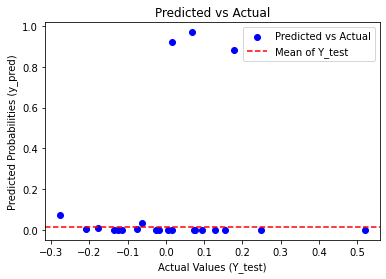

In [813]:
plt.scatter(Y_test, y_pred, color="blue", label="Predicted vs Actual")
plt.xlabel("Actual Values (Y_test)")
plt.ylabel("Predicted Probabilities (y_pred)")
plt.axhline(y=np.mean(Y_test), color="red", linestyle="dashed", label="Mean of Y_test")
plt.legend()
plt.title("Predicted vs Actual")
plt.show()
